# Scientific Computing 4: Mass-spring physics model
This program implements a customizable mass-spring system in 2D to simulate a rubber block dropping on the ground and bouncing under the effect of gravity. It uses *Hooke's law* to model the springs, with all springs having the same stiffness $k$ and rest length $L$, as well as all mass points having the same mass $m$ and viscous damping $\gamma$.

The following default parameters are used:
- Point mass $m = 0.001 kg$
- Spring stiffness $k = 1000 kg/s^2$
- Rest length $L = 0.01 m$
- Gravity acceleration $g = 9.81 m/s^2$
- Viscous damping coefficient $\gamma = 0$ or $\gamma = 0.001$

The rubber block is represented by simulating a regular triangular grid of $N = 5 \times 5$ mass points.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### Initalization
The parameters below can be changed, although the default parameters provide a reasonably realistic approximation of reality.

The ground, onto which the block bounces is represented by an ideal plane at $z = 0$. Any mass point below that level experiences an external upward force $\vec{f}_i^{ext} = [0, -kz_i]$. Similar sideward forces are applied when the mass points hit the walls. An additional gravitational downward force $\vec{f}_i^{ext} = [0, -mg]$ is applied at all times. An initial position $x_0$ and velocity $v_0$ can also be chosen.

The program uses the semi-implicit Euler method to propagate the mass-soring system in time, recording the spring energy $U$, the kinetic energy $K$, the gravitational potential energy $P$, the contact energy $C$ and the total energy $T$ in each step. They are given by the following equations:

$U = \frac{k}{2} \sum\limits_{j=1}^{M} (l_j - L)^2$, &nbsp; $K = \frac{m}{2} \sum\limits_{i=1}^{N} \lVert \vec{v}_i \rVert^2$, &nbsp; $P = mg \sum\limits_{i=1}^{N} Z_i$, &nbsp; $C = \frac{k}{2} \sum\limits_{i=1}^{N} z_i^2 \delta_{z_i < 0}$ &nbsp; where &nbsp; $\delta_{z_i<0} = \begin{cases} 1 & \text{if } z_i < 0 \\ 0 & \text{otherwise} \end{cases}$

The total energy is given by $T = U + K + P + C$ and all the energies are plotted on a $\log$ scale as a function of time.

In [43]:
# Physical parameters:
m = 0.001  # point mass [kg]
k = 1000  # spring stiffness [kg/s^2]
L = 0.01  # rest length [m]
g = 9.81  # gravity acceleration [m/s^2]
gamma = 0.  # viscous damping coefficient [kg/s] (0 = no damping)

# Set flag for walls that should be removed to False:
ground_flag = True
ceil_flag = False
left_flag = True
right_flag = True

ground = 0  # z position of the floor plot ylim
ceiling = 0.25  # z position of the ceiling and plot ylim
left_wall = -0.1  # x position of the barrier to the left and plot xlim
right_wall = 0.15  # x position of the barrier to the right and plot xlim

# Simulation parameters:
t_end = 6.  # simulation end time [s]
h = np.sqrt(m/k)/2  # simulation timestep [s]

n = 5  # number of mass points in each direction
N = n**2  # total number of mass points
M = (n-1) * (3*n-1)  # number of springs connecting the mass points

# Initial position and velocity:
x0 = np.array([-0.09, 0.26])  # starting position of lower left corner [m]
v0 = np.array([0.2, 0.0])  # starting velocity [m/s]

# Animation settings:
duration = 20  # video length [s]
FPS = 30  # video framerate [fps]

frames = duration * FPS  # total number of frames
steps_per_frame = int(round(t_end/h/frames))  # timesteps per frame

### Classes and functions

In [44]:
class Point:
    def __init__(self):
        self.x = np.zeros(2)  # position
        self.v = np.zeros(2)  # velocity
        self.f = np.zeros(2)  # force

        self.K = 0.  # kinetic energy
        self.P = 0.  # potential energy
        self.C = 0.  # contact energy

    def clear_force(self):
        self.f = np.zeros(2)

    def add_gravity(self):
        self.f[1] = self.f[1] - m * g  # current force + downwards gravity

        self.P = self.x[1] * m * g  # calculate potential energy

    def add_damping(self):
        self.f = self.f - self.v * gamma

    def add_walls(self):
        left_C, right_C, ground_C = 0, 0, 0

        if ground_flag:
            self.f[1] = self.f[1] - self.x[1] * k * (self.x[1] < ground)
            ground_C = k/2 * self.x[1]**2 * (self.x[1] < ground)
        if left_flag and self.x[0] < left_wall:
            self.f[0] = self.f[0] + (left_wall - self.x[0]) * k
            left_C = k/2 * (left_wall - self.x[0])**2
        if right_flag and self.x[0] > right_wall:
            self.f[0] = self.f[0] - (self.x[0] - right_wall) * k
            right_C = k/2 * (self.x[0] - right_wall)**2

        self.C = left_C + right_C + ground_C  # calculate contact energy

    def make_step(self):  # using semi-implicit Euler method
        self.v = self.v + h/m * self.f
        self.x = self.x + h * self.v

        self.K = m/2 * np.linalg.norm(self.v)**2  # calculate kinetic energy


class Spring:
    def __init__(self):
        self.p1 = 0  # index of first mass point
        self.p2 = 0  # index of second mass point

        self.f = np.zeros(2)  # spring force
        self.U = 0.  # spring energy

    def calculate_spring_force(self, points):
        dx = points[self.p1].x - points[self.p2].x  # spring vector
        l = np.linalg.norm(dx)  # length of spring vector

        self.f = -k * (l - L) / l * dx  # vector form of Hooke's law
        self.U = k/2 * (l - L)**2  # calculate spring energy

    def update_point_forces(self, points):
        points[self.p1].f = points[self.p1].f + self.f
        points[self.p2].f = points[self.p2].f - self.f

### Main code
As the indexing for connecting the points to the right springs is rather complicated, this part of the code was provided by the lecturer.

In [45]:
# Place the mass points:
points = [Point() for i in range(N)]
for i in range(n):
    for j in range(n):
        points[i*n+j].x = x0 + np.array([j*L + i % 2 * L/2, i*L * np.sqrt(3)/2])
        points[i*n+j].v = v0

# Connect the points by springs:
springs = [Spring() for j in range(M)]
for i in range(n):
    for j in range(n-1):
        s1 = i * (n-1) + j
        s2 = n * (n-1) + s1
        springs[s1].p1 = i * n + j
        springs[s1].p2 = i * n + j + 1
        springs[s2].p1 = j * n + i
        springs[s2].p2 = (j+1) * n + i

for i in range(n-1):
    for j in range(n-1):
        s = i * (n-1) + j + 2 * n * (n-1)
        springs[s].p1 = i * n + j + (i+1) % 2
        springs[s].p2 = (i+1) * n + j + i % 2

### Plot initialization
The initialized plot with the walls in grey can be seen before the simulation is run.

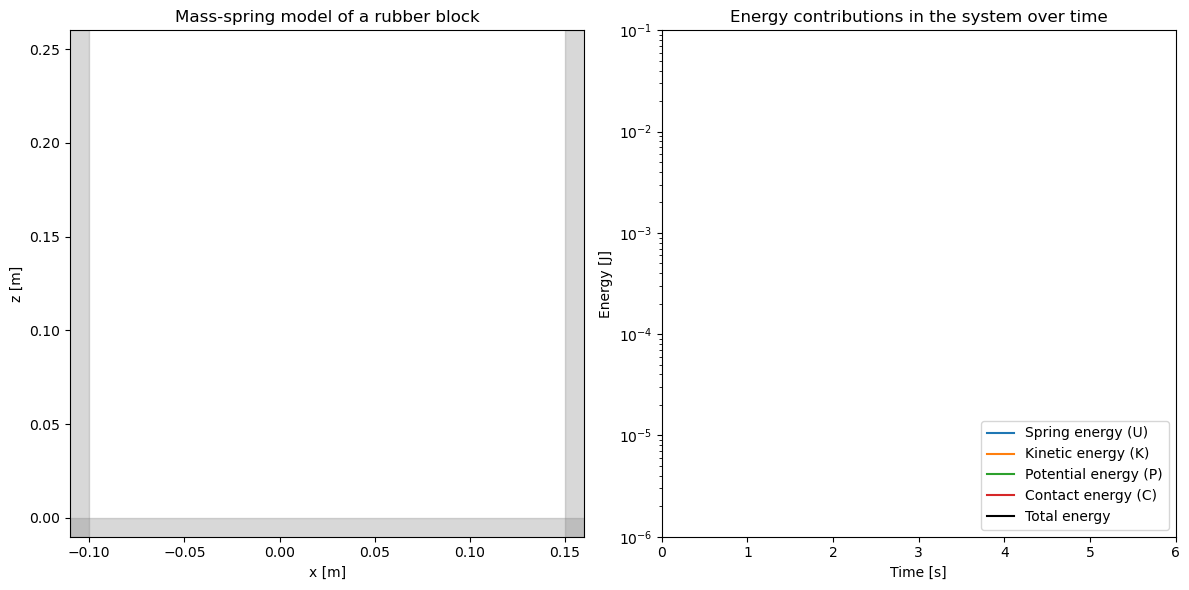

In [46]:
fig = plt.figure(figsize=(12, 6), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)

if ground_flag:  # make ground gray
    ax1.axhspan(ground - 0.05, ground, color="gray", alpha=0.3)
if ceil_flag:
    ax1.axhspan(ceiling, ceiling + 0.05, color="gray", alpha=0.3)
if left_flag:
    ax1.axvspan(left_wall - 0.05, left_wall, color="gray", alpha=0.3)
if right_flag:
    ax1.axvspan(right_wall, right_wall + 0.05, color="gray", alpha=0.3)


ax1.set_xlim(left_wall-0.01, right_wall + 0.01)
ax1.set_ylim(ground - 0.01, ceiling + 0.01)
ax1.set_title("Mass-spring model of a rubber block")
ax1.set_xlabel("x [m]")
ax1.set_ylabel("z [m]")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_yscale("log")
ax2.set_xlim(0, t_end)
ax2.set_ylim(1e-6, 1e-1)
ax2.set_title("Energy contributions in the system over time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Energy [J]")

# Draw shape that is simulated:
lines = [ax1.plot([], [], "m-", lw=2)[0] for _ in range(M)]

# Draw lines of energy diagram:
l1, = ax2.plot([], [], color="C0", label="Spring energy (U)")
l2, = ax2.plot([], [], color="C1", label="Kinetic energy (K)")
l3, = ax2.plot([], [], color="C2", label="Potential energy (P)")
l4, = ax2.plot([], [], color="C3", label="Contact energy (C)")
l5, = ax2.plot([], [], color="k", label="Total energy")

ax2.legend(loc="lower right")

data = [lines, l1, l2, l3, l4, l5]
t, U, K, P, C = [], [], [], [], []

plt.tight_layout()

### Run the simulation

In [47]:
def run_simulation(frame):
    for step in range(steps_per_frame):
        for i in range(N):  # calculate external forces
            points[i].clear_force()
            points[i].add_gravity()
            points[i].add_damping()
            points[i].add_walls()

        for j in range(M):  # calculate spring forces
            springs[j].calculate_spring_force(points)
            springs[j].update_point_forces(points)

        for i in range(N):  # make time step
            points[i].make_step()

    for j in range(M):
        x1 = points[springs[j].p1].x
        x2 = points[springs[j].p2].x
        data[0][j].set_data([x1[0], x2[0]], [x1[1], x2[1]])

    t.append(round(frame * steps_per_frame * h, 2))
    U.append(sum([springs[j].U for j in range(M)]))
    K.append(sum([points[i].K for i in range(N)]))
    P.append(sum([points[i].P for i in range(N)]))
    C.append(sum([points[i].C for i in range(N)]))
    T = np.array([U, K, P, C]).sum(axis=0)

    data[1].set_data(t, U)
    data[2].set_data(t, K)
    data[3].set_data(t, P)
    data[4].set_data(t, C)
    data[5].set_data(t, T)

    return data

### Save the simulation animation

In [48]:
ani = FuncAnimation(fig, run_simulation, frames=frames, interval=1000/FPS)
ani.save("output/mass_spring.gif", fps=FPS)

When damping is off, the rubber block bounces endlessly due to the symplectic nature of the semi-implicit Euler method, conserving the system's total energy (T, black). The conversion of part of the gravitational potential energy (P, green) into kinetic energy (K, orange) becomes apparent. The asymmetry in the block's shape leads to its rotation. The elastic spring energy (U, blue) remains nearly zero until the block's initial collision with the ground, triggering ongoing spring oscillations.

In contrast, enabling damping causes the elastic block to bounce only a few times before settling. The overall energy of the system (T, black) diminishes gradually towards a stable state. The exponential reduction of kinetic energy (K, orange) is characteristic of damped elastic systems. Damping also curtails spring oscillations, resulting in the decline of spring energy (U, blue), though it doesn't reach zero due to the block's gravitational compression. In the stable state, the spring energy due to gravitational compression (U, blue) approximates the energy from ground contact (C, red), signifying equilibrium between the two forces.